In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")


## Aladynoulli retrospective

Here we show the ability of the model to estatime when having access to all data for signature and genomic discovery, heterogeneity characterization, and cohort similarity.

In [2]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix_corrected.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/3629226493.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [4]:
import pandas as pd
pids=pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/csv/processed_ids.csv')['eid'].values

In [5]:

# Test reading the file
import pandas as pd
df = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/UKBWeights-main/UKBSelectionWeights.csv', sep='\s+', engine='python')
print(df.head())
print(df.columns)
print(df.shape)



       f.eid  LassoWeight
0  1482136.0     0.400256
1  4261840.0     0.746818
2  1021212.0     0.526333
3  3857942.0     0.411219
4  3868072.0     0.517283
Index(['f.eid', 'LassoWeight'], dtype='object')
(469553, 2)


In [10]:
import pandas as pd
import numpy as np
import torch
from weighted_aladyn_vec import * 
from weightedprev import *
# Config
N_Y = 400000  # set to the number of rows of Y (the slice of pids that corresponds to Y)
idx_start, idx_end = 0, 10000

# 1) Load covariates (must include f.eid, sex, and optional PC columns)
covariates_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv'
cov_df = pd.read_csv(covariates_path)

# Define column names present in your file
sex_col = 'sex'  # adjust if different (e.g., 'f.31.0.0' or similar)
pc_columns = [
    'f.22009.0.1','f.22009.0.2','f.22009.0.3','f.22009.0.4','f.22009.0.5',
    'f.22009.0.6','f.22009.0.7','f.22009.0.8','f.22009.0.9','f.22009.0.10'
]
use_pcs = True  # toggle if you do/don't want PCs

# 2) Build mapping from f.eid -> covariates
cov_df = cov_df[['identifier', sex_col] + (pc_columns if use_pcs else [])].dropna(subset=['identifier'])
cov_df = cov_df.drop_duplicates(subset=['identifier'])
cov_map = cov_df.set_index('identifier')

# 3) Create covariate arrays aligned to pids[:N_Y]
pids_y = pids[:N_Y]
sex_aligned = np.zeros(N_Y, dtype=float)
if use_pcs:
    pcs_aligned = np.zeros((N_Y, len(pc_columns)), dtype=float)

matched_cov = 0
for i, pid in enumerate(pids_y):
    if pid in cov_map.index:
        sex_aligned[i] = cov_map.at[pid, sex_col]
        if use_pcs:
            pcs_aligned[i, :] = cov_map.loc[pid, pc_columns].values
        matched_cov += 1
    else:
        # leave zeros if missing; you can choose an imputation if preferred
        pass

print(f"Covariates matched: {matched_cov} / {N_Y} ({matched_cov*100.0/N_Y:.1f}%)")

# 4) Subset Y/E/G and covariates to the same indices
Y_10k, E_10k, G_10k, indices = subset_data(Y, E, G, start_index=idx_start, end_index=idx_end)
sex_10k = sex_aligned[idx_start:idx_end].reshape(-1, 1)
if use_pcs:
    pcs_10k = pcs_aligned[idx_start:idx_end, :]

# 5) Combine G with covariates
if use_pcs:
    G_with_covs_10k = np.column_stack([G_10k, sex_10k, pcs_10k])
else:
    G_with_covs_10k = np.column_stack([G_10k, sex_10k])

print(f"G_with_covs_10k shape: {G_with_covs_10k.shape}")

# 6) Prepare weights aligned and subset to the same individuals
matched_weights, match_mask = match_weights_to_ids(df, pids[:N_Y])
weights_10k = matched_weights[idx_start:idx_end].copy()
num_unmatched_in_10k = int((weights_10k == 0).sum())
if num_unmatched_in_10k > 0:
    print(f"Warning: {num_unmatched_in_10k} of {idx_end - idx_start} had no matched weight; setting weight=1.0.")
    weights_10k[weights_10k == 0] = 1.0

Covariates matched: 400000 / 400000 (100.0%)
G_with_covs_10k shape: (10000, 47)
Matching weights to IDs...
  Weights available: 469553
  Processed IDs: 400000
  Matched: 376505 (94.1%)
  Unmatched: 23495


In [12]:
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
prevalence_t=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.pt')
# When initializing the model:


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/1363122406.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/C

In [13]:
# 7) Build weighted model using the augmented G
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest_weighted(
    N=Y_10k.shape[0],
    D=Y_10k.shape[1],
    T=Y_10k.shape[2],
    K=20,
    P=G_with_covs_10k.shape[1],
    G=G_with_covs_10k,
    Y=Y_10k,
    W=1e-4,
    R=0,
    prevalence_t=prevalence_t,
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=essentials['disease_names'],
    init_sd_scaler=1e-1,
    genetic_scale=1.0,
    learn_kappa=True,
    weights=weights_10k
)

# Optional: initialize with stored psi/clusters (ensure shapes match K)
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
print(f"Clusters match exactly: {np.array_equal(initial_clusters, model.clusters)}")




INVERSE PROBABILITY WEIGHTING ENABLED
Weight statistics:
  Mean: 1.000
  Std: 1.065
  Min: 0.185
  Max: 7.238

Effective sample size: 4684 out of 10000
Efficiency: 46.8%



/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/3594816515.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Clusters match exactly: True


# you can see that we use the full unmodified E matrix here

In [14]:
E_10k

tensor([[51, 51, 51,  ..., 51, 51, 51],
        [29, 29, 29,  ..., 29, 29, 29],
        [51, 51, 51,  ..., 51, 51, 51],
        ...,
        [43, 43, 43,  ..., 43, 43, 43],
        [42, 42, 42,  ..., 42, 42, 42],
        [32, 32, 32,  ..., 32, 32, 32]])

In [18]:
## now we will run the model with the full data and sex specific
import cProfile
import pstats
from pstats import SortKey
# 5. Train on FULL data
profiler = cProfile.Profile()
profiler.enable()

history_new = model.fit(E_10k, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.4321

Monitoring signature responses:

Disease 241 (signature 12, LR=32.71):
  Theta for diagnosed: 0.009 ± 0.002
  Theta for others: 0.009
  Proportion difference: -0.000

Disease 161 (signature 7, LR=30.91):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 321 (signature 1, LR=30.10):
  Theta for diagnosed: 0.082 ± 0.018
  Theta for others: 0.079
  Proportion difference: 0.003

Disease 336 (signature 9, LR=29.62):
  Theta for diagnosed: 0.031 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 186 (signature 2, LR=29.31):
  Theta for diagnosed: 0.069 ± 0.016
  Theta for others: 0.067
  Proportion difference: 0.001

Epoch 1
Loss: 707.3859

Monitoring signature responses:

Disease 241 (signature 12, LR=32.69):
  Theta for diagnosed: 0.008 ± 0.002
  Theta for others: 0.009
  Proportion difference: -0.000

Disease 161 (signature 7, LR=31.03):
  Theta for diagnosed: 0.151 ± 0.036
  Theta for othe

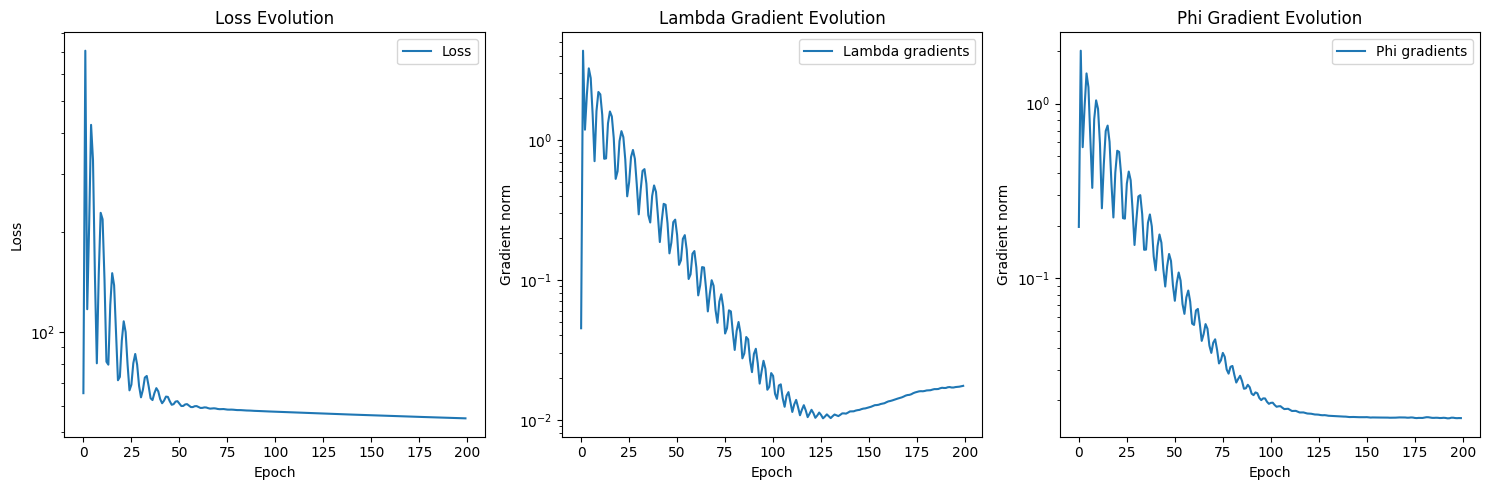

In [19]:
from utils import *
plot_training_evolution(history_new)

In [20]:

# Save model
W=0.0001
torch.save({
    'model_state_dict': model.state_dict(),
    'phi': model.phi,
    'Y': model.Y,
    'prevalence_t': model.prevalence_t,
    'logit_prevalence_t': model.logit_prev_t,
    'G': model.G,
}, f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W{W}_fulldata_sexspecific_withpcs_and_weights_vec_correctedE.pt')

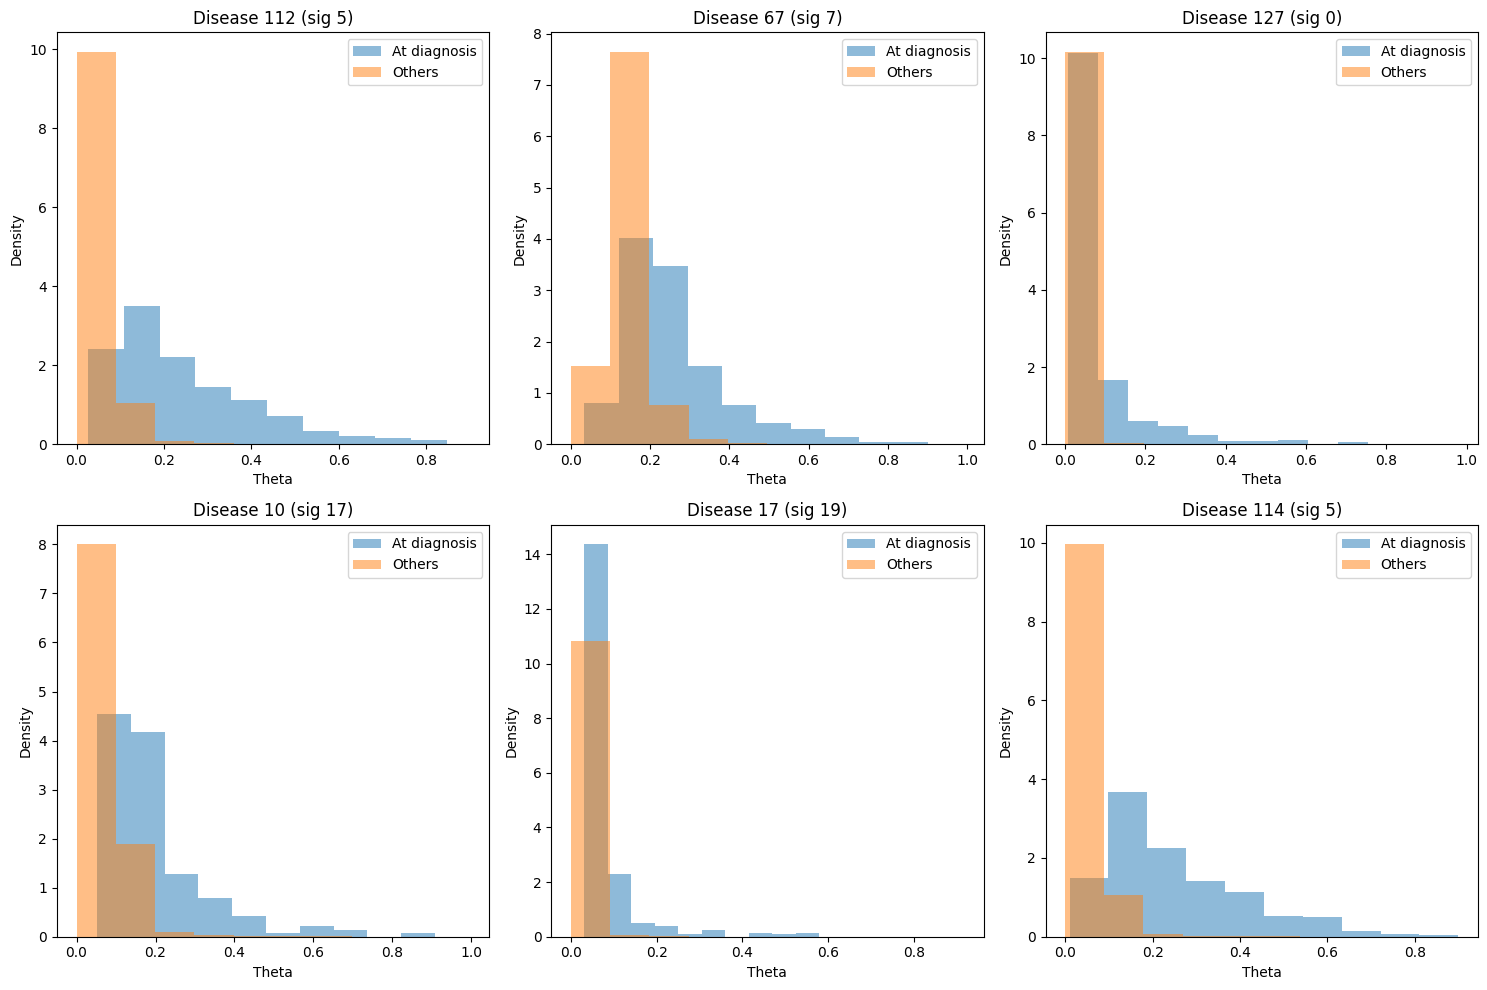

In [21]:

plot_theta_differences(model, diseases=[112,67,127,10,17,114], signatures=[5,7,0,17,19,5])

In [22]:
W = 0.0001  # or whatever W value you used
model_old = torch.load(f'/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2294348496.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_old = torch.load(f'/Users/sarahurbut/Lib

In [23]:
# Compare phi values between weighted and unweighted models
old_phi = model_old['phi']
new_phi = model.phi

print("=== PHI COMPARISON ===")
print(f"Old phi shape: {old_phi.shape}")
print(f"New phi shape: {new_phi.shape}")

# Basic statistics
print(f"\nOld phi stats:")
print(f"  Mean: {old_phi.mean():.4f}")
print(f"  Std: {old_phi.std():.4f}")
print(f"  Range: [{old_phi.min():.4f}, {old_phi.max():.4f}]")

print(f"\nNew phi stats:")
print(f"  Mean: {new_phi.mean():.4f}")
print(f"  Std: {new_phi.std():.4f}")
print(f"  Range: [{new_phi.min():.4f}, {new_phi.max():.4f}]")

# Difference analysis
phi_diff = new_phi - old_phi
print(f"\nDifference (new - old):")
print(f"  Mean diff: {phi_diff.mean():.4f}")
print(f"  Std diff: {phi_diff.std():.4f}")
print(f"  Range: [{phi_diff.min():.4f}, {phi_diff.max():.4f}]")

# Correlation
phi_corr = torch.corrcoef(torch.stack([old_phi.flatten(), new_phi.flatten()]))[0,1]
print(f"\nCorrelation between old and new phi: {phi_corr:.4f}")

# Per-signature comparison
print(f"\nPer-signature mean differences:")
for k in range(min(old_phi.shape[0], new_phi.shape[0])):
    sig_diff = (new_phi[k] - old_phi[k]).mean()
    print(f"  Signature {k}: {sig_diff:.4f}")

# Per-disease comparison  
print(f"\nPer-disease mean differences:")
for d in range(min(old_phi.shape[1], new_phi.shape[1])):
    dis_diff = (new_phi[:,d] - old_phi[:,d]).mean()
    print(f"  Disease {d}: {dis_diff:.4f}")







=== PHI COMPARISON ===
Old phi shape: torch.Size([21, 348, 52])
New phi shape: torch.Size([21, 348, 52])

Old phi stats:
  Mean: -10.9056
  Std: 2.5700
  Range: [-22.8308, -1.7358]

New phi stats:
  Mean: -10.9025
  Std: 2.5708
  Range: [-22.7053, -1.9921]

Difference (new - old):
  Mean diff: 0.0031
  Std diff: 0.1457
  Range: [-1.0149, 1.5892]

Correlation between old and new phi: 0.9984

Per-signature mean differences:
  Signature 0: 0.0045
  Signature 1: 0.0086
  Signature 2: 0.0002
  Signature 3: 0.0007
  Signature 4: 0.0058
  Signature 5: 0.0110
  Signature 6: -0.0081
  Signature 7: 0.0068
  Signature 8: 0.0029
  Signature 9: 0.0066
  Signature 10: -0.0032
  Signature 11: 0.0031
  Signature 12: 0.0042
  Signature 13: -0.0015
  Signature 14: 0.0126
  Signature 15: -0.0044
  Signature 16: 0.0118
  Signature 17: -0.0105
  Signature 18: 0.0083
  Signature 19: 0.0019
  Signature 20: 0.0036

Per-disease mean differences:
  Disease 0: -0.0195
  Disease 1: -0.0154
  Disease 2: -0.0556
  

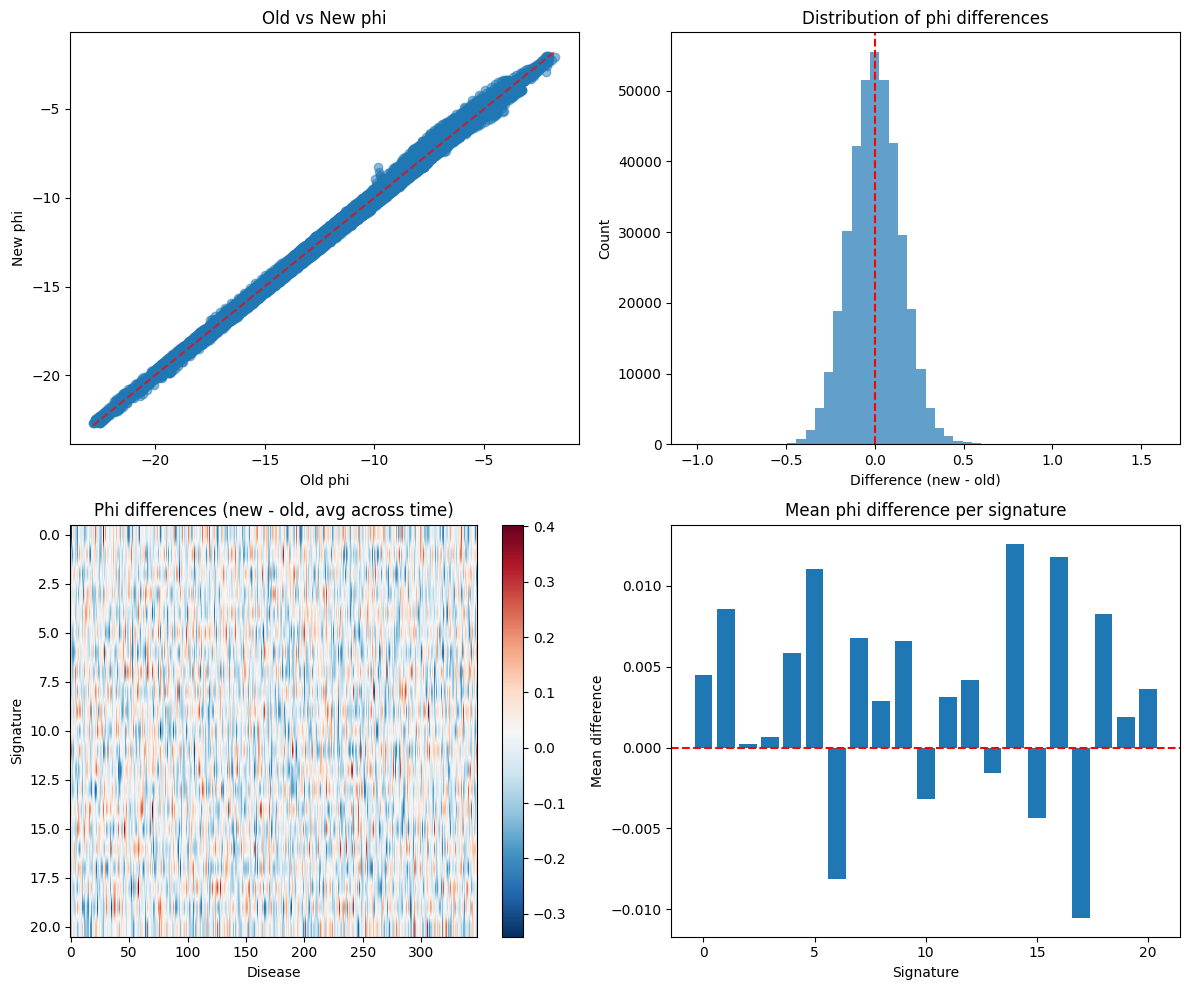

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot phi comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Scatter plot: old vs new phi
axes[0,0].scatter(old_phi.detach().numpy().flatten(), new_phi.detach().numpy().flatten(), alpha=0.5)
axes[0,0].plot([old_phi.detach().min(), old_phi.detach().max()], [old_phi.detach().min(), old_phi.detach().max()], 'r--', alpha=0.7)
axes[0,0].set_xlabel('Old phi')
axes[0,0].set_ylabel('New phi')
axes[0,0].set_title('Old vs New phi')

# 2. Difference histogram
phi_diff = new_phi - old_phi
axes[0,1].hist(phi_diff.detach().numpy().flatten(), bins=50, alpha=0.7)
axes[0,1].axvline(0, color='red', linestyle='--')
axes[0,1].set_xlabel('Difference (new - old)')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of phi differences')

# 3. Heatmap of differences by signature and disease (averaged across time)
diff_matrix = phi_diff.mean(dim=2).detach().numpy()  # Average across time dimension
im = axes[1,0].imshow(diff_matrix, aspect='auto', cmap='RdBu_r')
axes[1,0].set_xlabel('Disease')
axes[1,0].set_ylabel('Signature')
axes[1,0].set_title('Phi differences (new - old, avg across time)')
plt.colorbar(im, ax=axes[1,0])

# 4. Mean difference per signature (average across both diseases and time)
sig_means = phi_diff.mean(dim=(1,2)).detach().numpy()  # Average across diseases AND time
axes[1,1].bar(range(len(sig_means)), sig_means)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_xlabel('Signature')
axes[1,1].set_ylabel('Mean difference')
axes[1,1].set_title('Mean phi difference per signature')

plt.tight_layout()
plt.show()

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/284196259.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


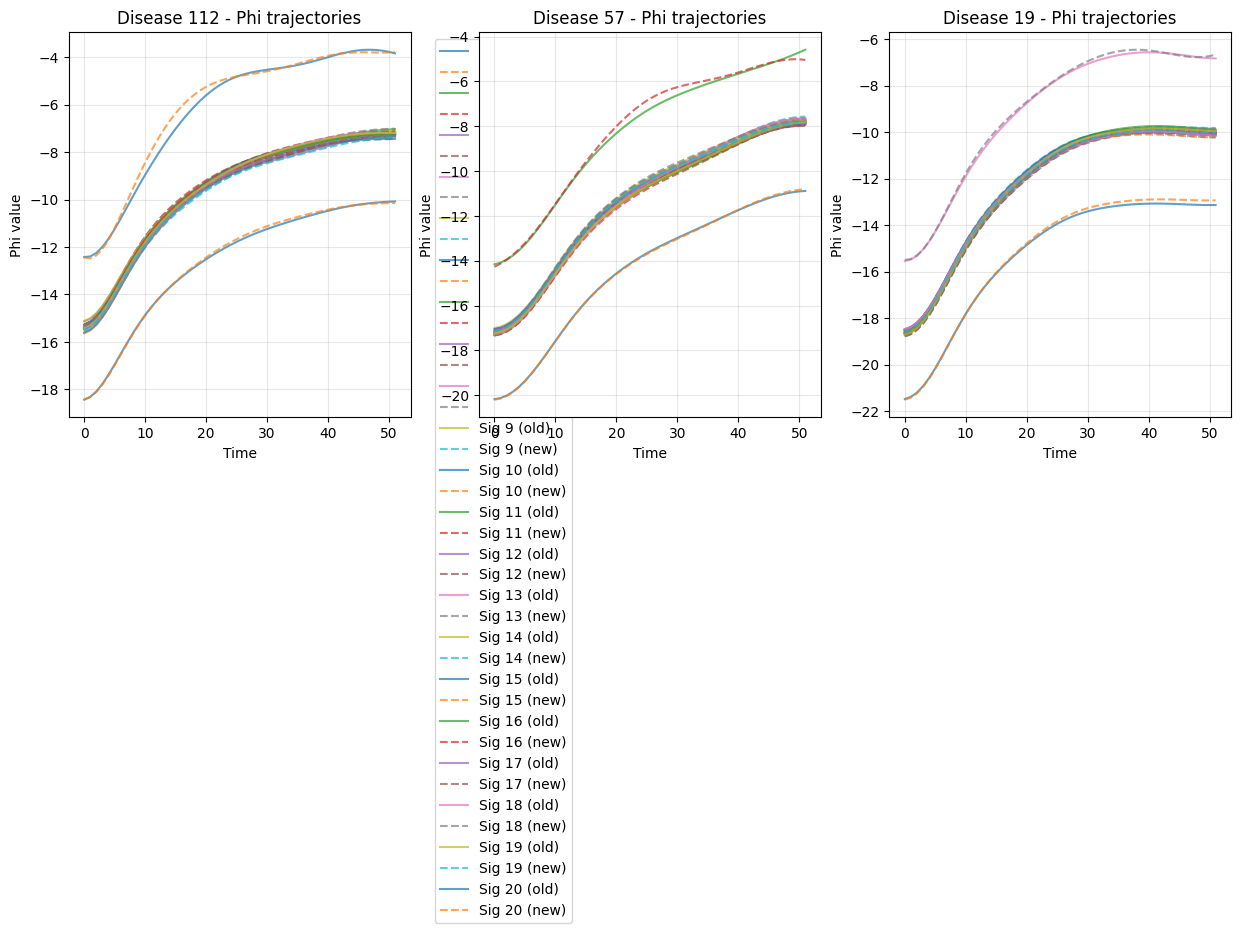

In [25]:
import matplotlib.pyplot as plt

# Plot phi trajectories for specific diseases
diseases_to_plot = [112, 57, 19]
fig, axes = plt.subplots(1, len(diseases_to_plot), figsize=(15, 5))

for i, d in enumerate(diseases_to_plot):
    ax = axes[i] if len(diseases_to_plot) > 1 else axes
    
    # Plot phi trajectories for all signatures for this disease
    for k in range(old_phi.shape[0]):  # All signatures
        old_traj = old_phi[k, d, :].detach().numpy()
        new_traj = new_phi[k, d, :].detach().numpy()
        
        ax.plot(old_traj, alpha=0.7, linestyle='-', label=f'Sig {k} (old)' if i == 0 else "")
        ax.plot(new_traj, alpha=0.7, linestyle='--', label=f'Sig {k} (new)' if i == 0 else "")
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Phi value')
    ax.set_title(f'Disease {d} - Phi trajectories')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
# Find signature/disease combinations with largest differences
phi_diff = new_phi - old_phi

# Get absolute differences
abs_diff = torch.abs(phi_diff)

# Find maximum difference across all dimensions
max_diff_val, max_indices = torch.max(abs_diff.view(-1), dim=0)
max_idx = max_indices.item()

# Convert flat index back to 3D coordinates
k_max, d_max, t_max = np.unravel_index(max_idx, phi_diff.shape)

print(f"Largest absolute difference: {max_diff_val:.4f}")
print(f"Location: Signature {k_max}, Disease {d_max}, Time {t_max}")
print(f"Old value: {old_phi[k_max, d_max, t_max]:.4f}")
print(f"New value: {new_phi[k_max, d_max, t_max]:.4f}")
print(f"Difference: {phi_diff[k_max, d_max, t_max]:.4f}")

# Top 10 largest differences
print(f"\nTop 10 largest absolute differences:")
flat_diff = abs_diff.view(-1)
top_10_vals, top_10_indices = torch.topk(flat_diff, 10)

for i, (val, idx) in enumerate(zip(top_10_vals, top_10_indices)):
    k, d, t = np.unravel_index(idx.item(), phi_diff.shape)
    actual_diff = phi_diff[k, d, t].item()
    print(f"{i+1:2d}. Sig {k:2d}, Dis {d:3d}, Time {t:2d}: {actual_diff:+.4f} (abs: {val:.4f})")

# Per-signature maximum differences
print(f"\nMaximum difference per signature:")
for k in range(phi_diff.shape[0]):
    sig_max = torch.max(abs_diff[k]).item()
    sig_max_idx = torch.argmax(abs_diff[k]).item()
    d_max_sig, t_max_sig = np.unravel_index(sig_max_idx, phi_diff[k].shape)
    actual_diff_sig = phi_diff[k, d_max_sig, t_max_sig].item()
    print(f"Signature {k:2d}: {actual_diff_sig:+.4f} at Disease {d_max_sig:3d}, Time {t_max_sig:2d}")

Largest absolute difference: 1.5892
Location: Signature 15, Disease 46, Time 0
Old value: -9.8347
New value: -8.2455
Difference: 1.5892

Top 10 largest absolute differences:
 1. Sig 15, Dis  46, Time  0: +1.5892 (abs: 1.5892)
 2. Sig 15, Dis  46, Time  1: +1.2463 (abs: 1.2463)
 3. Sig  0, Dis 119, Time 24: +1.1209 (abs: 1.1209)
 4. Sig  0, Dis 119, Time 23: +1.1118 (abs: 1.1118)
 5. Sig  0, Dis 119, Time 25: +1.1026 (abs: 1.1026)
 6. Sig  0, Dis 119, Time 22: +1.0827 (abs: 1.0827)
 7. Sig  0, Dis 119, Time 26: +1.0525 (abs: 1.0525)
 8. Sig  3, Dis 267, Time  0: +1.0364 (abs: 1.0364)
 9. Sig 16, Dis 204, Time 11: +1.0332 (abs: 1.0332)
10. Sig 18, Dis 210, Time  0: +1.0321 (abs: 1.0321)

Maximum difference per signature:
Signature  0: +1.1209 at Disease 119, Time 24
Signature  1: +0.8408 at Disease 334, Time 12
Signature  2: +0.9246 at Disease 191, Time 11
Signature  3: +1.0364 at Disease 267, Time  0
Signature  4: +0.7244 at Disease 150, Time  9
Signature  5: +1.0042 at Disease 115, Tim

In [27]:
# Convert phi differences to prevalence differences
old_prev = torch.sigmoid(old_phi)
new_prev = torch.sigmoid(new_phi)
prev_diff = new_prev - old_prev

print("=== PREVALENCE SCALE COMPARISON ===")
print(f"Old prevalence stats:")
print(f"  Mean: {old_prev.mean():.6f}")
print(f"  Range: [{old_prev.min():.6f}, {old_prev.max():.6f}]")

print(f"\nNew prevalence stats:")
print(f"  Mean: {new_prev.mean():.6f}")
print(f"  Range: [{new_prev.min():.6f}, {new_prev.max():.6f}]")

print(f"\nPrevalence differences (new - old):")
print(f"  Mean diff: {prev_diff.mean():.6f}")
print(f"  Std diff: {prev_diff.std():.6f}")
print(f"  Range: [{prev_diff.min():.6f}, {prev_diff.max():.6f}]")

# Find largest prevalence differences
abs_prev_diff = torch.abs(prev_diff)
max_prev_diff_val, max_prev_idx = torch.max(abs_prev_diff.view(-1), dim=0)
k_max, d_max, t_max = np.unravel_index(max_prev_idx.item(), prev_diff.shape)

print(f"\nLargest prevalence difference: {max_prev_diff_val:.6f}")
print(f"Location: Signature {k_max}, Disease {d_max}, Time {t_max}")
print(f"Old prevalence: {old_prev[k_max, d_max, t_max]:.6f}")
print(f"New prevalence: {new_prev[k_max, d_max, t_max]:.6f}")
print(f"Relative change: {100 * prev_diff[k_max, d_max, t_max] / old_prev[k_max, d_max, t_max]:.2f}%")

=== PREVALENCE SCALE COMPARISON ===
Old prevalence stats:
  Mean: 0.000214
  Range: [0.000000, 0.149852]

New prevalence stats:
  Mean: 0.000210
  Range: [0.000000, 0.120039]

Prevalence differences (new - old):
  Mean diff: -0.000003
  Std diff: 0.000367
  Range: [-0.050168, 0.017157]

Largest prevalence difference: 0.050168
Location: Signature 15, Disease 47, Time 51
Old prevalence: 0.102721
New prevalence: 0.052554
Relative change: -48.84%


In [28]:
disease_names=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x'].values

In [29]:
import pandas as pd
import numpy as np
import torch
from weighted_aladyn_vec import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest_weighted, subset_data

# Config
N_Y = 400000  # rows of Y corresponding to pids[:N_Y]
batch_size = 10000
n_batches = 10

# Load covariates
covariates_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv'
cov_df = pd.read_csv(covariates_path)

sex_col = 'sex'
pc_columns = [
    'f.22009.0.1','f.22009.0.2','f.22009.0.3','f.22009.0.4','f.22009.0.5',
    'f.22009.0.6','f.22009.0.7','f.22009.0.8','f.22009.0.9','f.22009.0.10'
]
use_pcs = True

# Build covariate mapping
cov_df = cov_df[['identifier', sex_col] + (pc_columns if use_pcs else [])].dropna(subset=['identifier'])
cov_df = cov_df.drop_duplicates(subset=['identifier'])
cov_map = cov_df.set_index('identifier')

# Match weights to all pids[:N_Y]
matched_weights, match_mask = match_weights_to_ids(df, pids[:N_Y])

# Run batches
results = []
for batch_idx in range(n_batches):
    print(f"\n{'='*60}")
    print(f"BATCH {batch_idx + 1}/{n_batches}")
    print(f"{'='*60}")
    
    # Calculate batch indices
    idx_start = batch_idx * batch_size
    idx_end = min((batch_idx + 1) * batch_size, N_Y)
    
    print(f"Processing individuals {idx_start} to {idx_end-1}")
    
    # Subset data
    Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G, start_index=idx_start, end_index=idx_end)
    
    # Subset covariates
    pids_batch = pids[idx_start:idx_end]
    sex_batch = np.zeros(len(pids_batch), dtype=float)
    if use_pcs:
        pcs_batch = np.zeros((len(pids_batch), len(pc_columns)), dtype=float)
    
    matched_cov_batch = 0
    for i, pid in enumerate(pids_batch):
        if pid in cov_map.index:
            sex_batch[i] = cov_map.at[pid, sex_col]
            if use_pcs:
                pcs_batch[i, :] = cov_map.loc[pid, pc_columns].values
            matched_cov_batch += 1
    
    print(f"Covariates matched: {matched_cov_batch} / {len(pids_batch)} ({matched_cov_batch*100.0/len(pids_batch):.1f}%)")
    
    # Combine G with covariates
    sex_batch = sex_batch.reshape(-1, 1)
    if use_pcs:
        G_with_covs_batch = np.column_stack([G_batch, sex_batch, pcs_batch])
    else:
        G_with_covs_batch = np.column_stack([G_batch, sex_batch])
    
    # Subset weights
    weights_batch = matched_weights[idx_start:idx_end].copy()
    num_unmatched = int((weights_batch == 0).sum())
    if num_unmatched > 0:
        print(f"Warning: {num_unmatched} had no matched weight; setting weight=1.0.")
        weights_batch[weights_batch == 0] = 1.0
    
    print(f"Weight stats: mean={weights_batch.mean():.3f}, std={weights_batch.std():.3f}")
    
    # Build model
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest_weighted(
        N=Y_batch.shape[0],
        D=Y_batch.shape[1],
        T=Y_batch.shape[2],
        K=20,
        P=G_with_covs_batch.shape[1],
        G=G_with_covs_batch,
        Y=Y_batch,
        W=1e-4,
        R=0,
        prevalence_t=prevalence_t,
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials['disease_names'],
        init_sd_scaler=1e-1,
        genetic_scale=1.0,
        learn_kappa=True,
        weights=weights_batch
    )
    
    # Initialize with stored psi/clusters
    initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
    initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
    model.initialize_params(true_psi=initial_psi)
    model.clusters = initial_clusters
    
    # Train
    print("Training...")
    losses, grads = model.fit(event_times=E_batch, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
    
    # Store results
    results.append({
        'batch_idx': batch_idx,
        'model': model,
        'losses': losses,
        'weights_stats': {
            'mean': weights_batch.mean(),
            'std': weights_batch.std(),
            'min': weights_batch.min(),
            'max': weights_batch.max()
        },
        'final_loss': losses[-1] if losses else None
    })
    
    print(f"Batch {batch_idx + 1} complete. Final loss: {losses[-1]:.4f}")

print(f"\n{'='*60}")
print(f"ALL {n_batches} BATCHES COMPLETE")
print(f"{'='*60}")

Matching weights to IDs...
  Weights available: 469553
  Processed IDs: 400000
  Matched: 376505 (94.1%)
  Unmatched: 23495

BATCH 1/10
Processing individuals 0 to 9999
Covariates matched: 10000 / 10000 (100.0%)
Weight stats: mean=0.916, std=0.976

INVERSE PROBABILITY WEIGHTING ENABLED
Weight statistics:
  Mean: 1.000
  Std: 1.065
  Min: 0.185
  Max: 7.238

Effective sample size: 4684 out of 10000
Efficiency: 46.8%


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.4817

Monitoring signature responses:

Disease 161 (signature 7, LR=29.54):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 131 (signature 0, LR=28.75):
  Theta for diagnosed: 0.028 ± 0.021
  Theta for others: 0.028
  Proportion difference: 0.001

Disease 343 (signature 7, LR=28.56):
  Theta for diagnosed: 0.150 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 149 (signature 3, LR=28.53):
  Theta for diagnosed: 0.145 ± 0.068
  Theta for others: 0.150
  Proportion difference: -0.005

Disease 15 (signature 19, LR=28.41):
  Theta for diagnosed: 0.046 ± 0.008
  Theta for others: 0.046
  Proportion difference: 0.001

Epoch 1
Loss: 707.4340

Monitoring signature responses:

Disease 161 (signature 7, LR=29.72):
  Theta for diagnosed: 0.151 ± 0.036
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 131 (signature 0, LR=28.90):
  Theta for diagnosed: 0.028 ± 0.020
  Theta for others:

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 64.0666

Monitoring signature responses:

Disease 310 (signature 1, LR=31.21):
  Theta for diagnosed: 0.080 ± 0.017
  Theta for others: 0.080
  Proportion difference: 0.000

Disease 107 (signature 0, LR=30.35):
  Theta for diagnosed: 0.028 ± 0.021
  Theta for others: 0.028
  Proportion difference: 0.001

Disease 231 (signature 19, LR=29.70):
  Theta for diagnosed: 0.046 ± 0.008
  Theta for others: 0.046
  Proportion difference: -0.000

Disease 341 (signature 7, LR=29.57):
  Theta for diagnosed: 0.153 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.006

Disease 28 (signature 6, LR=28.70):
  Theta for diagnosed: 0.011 ± 0.007
  Theta for others: 0.010
  Proportion difference: 0.000

Epoch 1
Loss: 705.8467

Monitoring signature responses:

Disease 310 (signature 1, LR=31.17):
  Theta for diagnosed: 0.080 ± 0.016
  Theta for others: 0.080
  Proportion difference: 0.000

Disease 107 (signature 0, LR=30.36):
  Theta for diagnosed: 0.028 ± 0.020
  Theta for others:

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.2841

Monitoring signature responses:

Disease 161 (signature 7, LR=30.68):
  Theta for diagnosed: 0.150 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 336 (signature 9, LR=29.35):
  Theta for diagnosed: 0.030 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 163 (signature 14, LR=28.54):
  Theta for diagnosed: 0.025 ± 0.014
  Theta for others: 0.024
  Proportion difference: 0.001

Disease 95 (signature 19, LR=28.51):
  Theta for diagnosed: 0.045 ± 0.008
  Theta for others: 0.046
  Proportion difference: -0.000

Disease 19 (signature 8, LR=28.23):
  Theta for diagnosed: 0.096 ± 0.080
  Theta for others: 0.087
  Proportion difference: 0.008

Epoch 1
Loss: 707.4639

Monitoring signature responses:

Disease 161 (signature 7, LR=30.81):
  Theta for diagnosed: 0.150 ± 0.037
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 336 (signature 9, LR=29.53):
  Theta for diagnosed: 0.030 ± 0.004
  Theta for others:

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 68.0830

Monitoring signature responses:

Disease 141 (signature 3, LR=33.51):
  Theta for diagnosed: 0.150 ± 0.072
  Theta for others: 0.150
  Proportion difference: -0.000

Disease 310 (signature 1, LR=31.99):
  Theta for diagnosed: 0.081 ± 0.018
  Theta for others: 0.079
  Proportion difference: 0.002

Disease 336 (signature 9, LR=30.18):
  Theta for diagnosed: 0.031 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 186 (signature 2, LR=30.12):
  Theta for diagnosed: 0.069 ± 0.016
  Theta for others: 0.067
  Proportion difference: 0.001

Disease 95 (signature 19, LR=29.54):
  Theta for diagnosed: 0.046 ± 0.008
  Theta for others: 0.046
  Proportion difference: 0.000

Epoch 1
Loss: 709.9514

Monitoring signature responses:

Disease 141 (signature 3, LR=33.54):
  Theta for diagnosed: 0.150 ± 0.071
  Theta for others: 0.150
  Proportion difference: -0.000

Disease 310 (signature 1, LR=31.96):
  Theta for diagnosed: 0.081 ± 0.016
  Theta for others

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.6069

Monitoring signature responses:

Disease 85 (signature 10, LR=30.30):
  Theta for diagnosed: 0.026 ± 0.023
  Theta for others: 0.026
  Proportion difference: 0.001

Disease 310 (signature 1, LR=30.06):
  Theta for diagnosed: 0.079 ± 0.017
  Theta for others: 0.080
  Proportion difference: -0.001

Disease 161 (signature 7, LR=29.71):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 99 (signature 19, LR=28.87):
  Theta for diagnosed: 0.046 ± 0.008
  Theta for others: 0.046
  Proportion difference: 0.001

Disease 241 (signature 12, LR=28.73):
  Theta for diagnosed: 0.009 ± 0.002
  Theta for others: 0.009
  Proportion difference: 0.000

Epoch 1
Loss: 707.7210

Monitoring signature responses:

Disease 85 (signature 10, LR=30.42):
  Theta for diagnosed: 0.026 ± 0.023
  Theta for others: 0.026
  Proportion difference: 0.001

Disease 310 (signature 1, LR=30.05):
  Theta for diagnosed: 0.079 ± 0.016
  Theta for others

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 66.1467

Monitoring signature responses:

Disease 42 (signature 3, LR=30.86):
  Theta for diagnosed: 0.150 ± 0.069
  Theta for others: 0.150
  Proportion difference: 0.000

Disease 198 (signature 17, LR=30.39):
  Theta for diagnosed: 0.088 ± 0.019
  Theta for others: 0.086
  Proportion difference: 0.002

Disease 85 (signature 10, LR=29.85):
  Theta for diagnosed: 0.026 ± 0.023
  Theta for others: 0.026
  Proportion difference: 0.001

Disease 76 (signature 7, LR=29.81):
  Theta for diagnosed: 0.152 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.005

Disease 240 (signature 12, LR=29.57):
  Theta for diagnosed: 0.009 ± 0.002
  Theta for others: 0.009
  Proportion difference: 0.000

Epoch 1
Loss: 708.1041

Monitoring signature responses:

Disease 42 (signature 3, LR=30.85):
  Theta for diagnosed: 0.150 ± 0.068
  Theta for others: 0.150
  Proportion difference: 0.000

Disease 198 (signature 17, LR=30.34):
  Theta for diagnosed: 0.088 ± 0.017
  Theta for others: 

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 66.9863

Monitoring signature responses:

Disease 310 (signature 1, LR=31.72):
  Theta for diagnosed: 0.080 ± 0.018
  Theta for others: 0.080
  Proportion difference: 0.000

Disease 85 (signature 10, LR=31.62):
  Theta for diagnosed: 0.026 ± 0.023
  Theta for others: 0.026
  Proportion difference: 0.000

Disease 30 (signature 6, LR=29.61):
  Theta for diagnosed: 0.011 ± 0.007
  Theta for others: 0.010
  Proportion difference: 0.000

Disease 161 (signature 7, LR=29.11):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 141 (signature 3, LR=28.73):
  Theta for diagnosed: 0.151 ± 0.072
  Theta for others: 0.150
  Proportion difference: 0.001

Epoch 1
Loss: 709.0768

Monitoring signature responses:

Disease 85 (signature 10, LR=31.78):
  Theta for diagnosed: 0.026 ± 0.023
  Theta for others: 0.026
  Proportion difference: 0.000

Disease 310 (signature 1, LR=31.67):
  Theta for diagnosed: 0.080 ± 0.016
  Theta for others: 0

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 66.7870

Monitoring signature responses:

Disease 136 (signature 11, LR=30.02):
  Theta for diagnosed: 0.008 ± 0.006
  Theta for others: 0.008
  Proportion difference: 0.000

Disease 161 (signature 7, LR=29.51):
  Theta for diagnosed: 0.150 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 19 (signature 8, LR=29.10):
  Theta for diagnosed: 0.094 ± 0.078
  Theta for others: 0.087
  Proportion difference: 0.007

Disease 283 (signature 8, LR=28.16):
  Theta for diagnosed: 0.095 ± 0.079
  Theta for others: 0.087
  Proportion difference: 0.008

Disease 224 (signature 3, LR=27.95):
  Theta for diagnosed: 0.152 ± 0.070
  Theta for others: 0.150
  Proportion difference: 0.001

Epoch 1
Loss: 708.4641

Monitoring signature responses:

Disease 136 (signature 11, LR=30.02):
  Theta for diagnosed: 0.008 ± 0.006
  Theta for others: 0.008
  Proportion difference: 0.000

Disease 161 (signature 7, LR=29.63):
  Theta for diagnosed: 0.150 ± 0.036
  Theta for others:

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 66.3792

Monitoring signature responses:

Disease 241 (signature 12, LR=30.69):
  Theta for diagnosed: 0.009 ± 0.002
  Theta for others: 0.009
  Proportion difference: 0.000

Disease 307 (signature 1, LR=30.41):
  Theta for diagnosed: 0.081 ± 0.018
  Theta for others: 0.080
  Proportion difference: 0.001

Disease 321 (signature 1, LR=29.43):
  Theta for diagnosed: 0.083 ± 0.019
  Theta for others: 0.079
  Proportion difference: 0.003

Disease 161 (signature 7, LR=28.04):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.004

Disease 226 (signature 17, LR=27.39):
  Theta for diagnosed: 0.087 ± 0.019
  Theta for others: 0.086
  Proportion difference: 0.001

Epoch 1
Loss: 708.3813

Monitoring signature responses:

Disease 241 (signature 12, LR=30.70):
  Theta for diagnosed: 0.009 ± 0.002
  Theta for others: 0.009
  Proportion difference: 0.000

Disease 307 (signature 1, LR=30.45):
  Theta for diagnosed: 0.080 ± 0.017
  Theta for other

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalenc

Initializing with 20 disease states + 1 healthy state
Initialization complete!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/2697553852.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/

Initializing with 20 disease states + 1 healthy state
Initialization complete!
Training...


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/weighted_aladyn_vec.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 66.9445

Monitoring signature responses:

Disease 76 (signature 7, LR=31.97):
  Theta for diagnosed: 0.152 ± 0.040
  Theta for others: 0.147
  Proportion difference: 0.005

Disease 341 (signature 7, LR=29.65):
  Theta for diagnosed: 0.152 ± 0.040
  Theta for others: 0.147
  Proportion difference: 0.005

Disease 86 (signature 10, LR=29.42):
  Theta for diagnosed: 0.026 ± 0.024
  Theta for others: 0.026
  Proportion difference: 0.000

Disease 332 (signature 7, LR=29.16):
  Theta for diagnosed: 0.153 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.006

Disease 227 (signature 19, LR=29.15):
  Theta for diagnosed: 0.045 ± 0.008
  Theta for others: 0.046
  Proportion difference: -0.001

Epoch 1
Loss: 708.5924

Monitoring signature responses:

Disease 76 (signature 7, LR=31.95):
  Theta for diagnosed: 0.152 ± 0.038
  Theta for others: 0.148
  Proportion difference: 0.004

Disease 341 (signature 7, LR=29.65):
  Theta for diagnosed: 0.152 ± 0.038
  Theta for others: 

Processing 10 batches from results object...

1. Saving batch models...
  Saved batch 0 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_00_model.pt
  Saved batch 1 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_01_model.pt
  Saved batch 2 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_02_model.pt
  Saved batch 3 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_03_model.pt
  Saved batch 4 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_04_model.pt
  Saved batch 5 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_05_model.pt
  Saved batch 6 to /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_06_model.pt
  Saved batch 7 to /Users

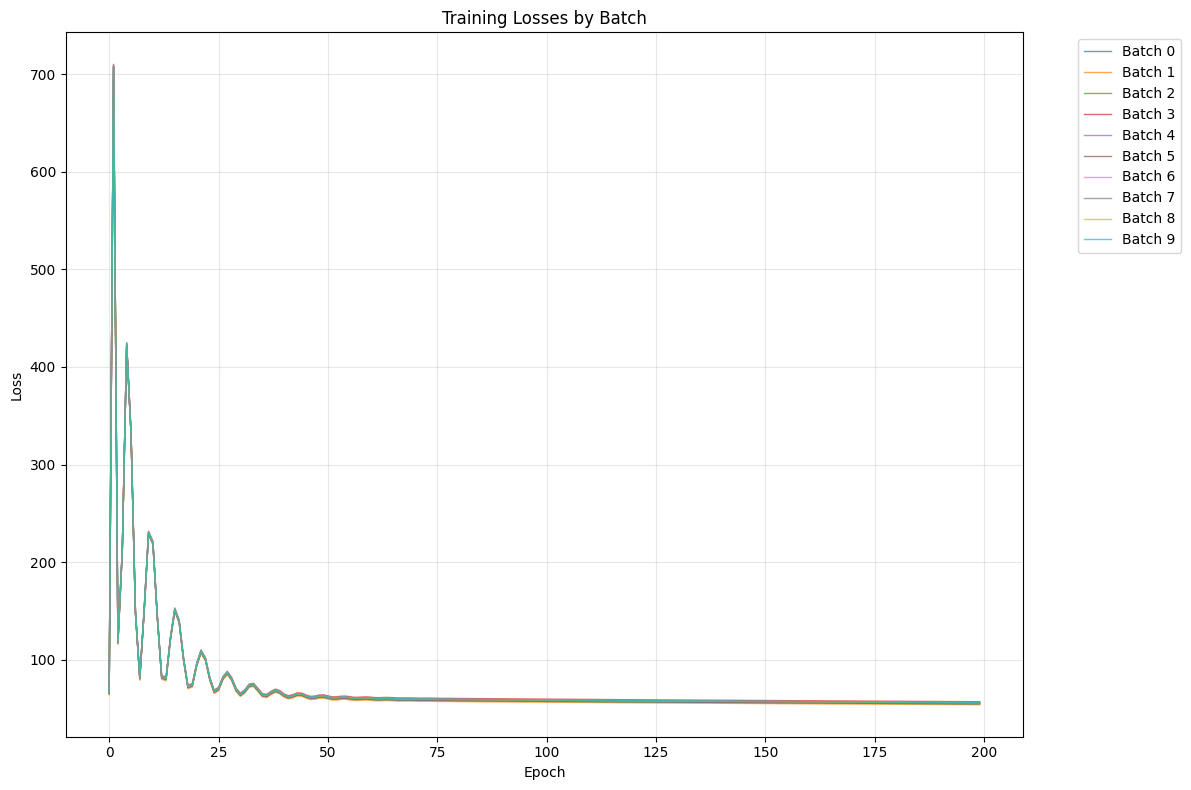

Loss comparison plot saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/batch_losses_comparison.png

3. Combining phis from all batches...
Phi shape: torch.Size([21, 348, 52])
  Batch 0: phi shape torch.Size([21, 348, 52])
  Batch 1: phi shape torch.Size([21, 348, 52])
  Batch 2: phi shape torch.Size([21, 348, 52])
  Batch 3: phi shape torch.Size([21, 348, 52])
  Batch 4: phi shape torch.Size([21, 348, 52])
  Batch 5: phi shape torch.Size([21, 348, 52])
  Batch 6: phi shape torch.Size([21, 348, 52])
  Batch 7: phi shape torch.Size([21, 348, 52])
  Batch 8: phi shape torch.Size([21, 348, 52])
  Batch 9: phi shape torch.Size([21, 348, 52])
Combined phi saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/combined_phi.pt
Combined phi shape: torch.Size([21, 348, 52])
Combined phi stats: mean=-10.9019, std=2.5692

BATCH TRAINING SUMMARY
Total batches: 10
Batch size: 10,000
Total patients: 100

In [30]:
# POST-PROCESSING: Save models, plot losses, combine phis

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# Create output directory
output_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/'
os.makedirs(output_dir, exist_ok=True)

print(f"Processing {len(results)} batches from results object...")

# 1. SAVE EACH BATCH MODEL (without losses)
print("\n1. Saving batch models...")
for i, result in enumerate(results):
    batch_idx = result['batch_idx']
    model = result['model']
    
    # Save model state dict (without losses)
    model_filename = f"batch_{batch_idx:02d}_model.pt"
    model_path = os.path.join(output_dir, model_filename)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'batch_idx': batch_idx,
        'weights_stats': result['weights_stats'],
        'final_loss': result['final_loss']
    }, model_path)
    
    print(f"  Saved batch {batch_idx} to {model_path}")

# 2. PLOT LOSSES COMPARISON
print("\n2. Plotting losses comparison...")
plt.figure(figsize=(12, 8))

for i, result in enumerate(results):
    batch_idx = result['batch_idx']
    losses = result['losses']
    
    if losses:
        plt.plot(losses, label=f'Batch {batch_idx}', alpha=0.7, linewidth=1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses by Batch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, 'batch_losses_comparison.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Loss comparison plot saved to: {plot_path}")

# 3. COMBINE/AVERAGE PHIS FROM ALL BATCHES
print("\n3. Combining phis from all batches...")

# Get phi shape from first batch
first_model = results[0]['model']
phi_shape = first_model.phi.shape
print(f"Phi shape: {phi_shape}")

# Initialize combined phi
combined_phi = torch.zeros(phi_shape)

# Sum phis from all batches
for i, result in enumerate(results):
    batch_idx = result['batch_idx']
    model = result['model']
    phi = model.phi.detach()
    combined_phi += phi
    print(f"  Batch {batch_idx}: phi shape {phi.shape}")

# Average the phis
combined_phi /= len(results)

# Save combined phi
combined_phi_path = os.path.join(output_dir, 'combined_phi.pt')
torch.save({
    'phi': combined_phi,
    'num_batches': len(results),
    'phi_shape': phi_shape
}, combined_phi_path)

print(f"Combined phi saved to: {combined_phi_path}")
print(f"Combined phi shape: {combined_phi.shape}")
print(f"Combined phi stats: mean={combined_phi.mean():.4f}, std={combined_phi.std():.4f}")

# 4. PRINT SUMMARY STATISTICS
print(f"\n{'='*60}")
print(f"BATCH TRAINING SUMMARY")
print(f"{'='*60}")

# Calculate statistics
all_losses = [result['final_loss'] for result in results if result['final_loss'] is not None]
all_weight_means = [result['weights_stats']['mean'] for result in results]

print(f"Total batches: {len(results)}")
print(f"Batch size: {batch_size:,}")
print(f"Total patients: {len(results) * batch_size:,}")

print(f"\nFinal Loss Statistics:")
print(f"  Average: {np.mean(all_losses):.4f} ± {np.std(all_losses):.4f}")
print(f"  Min: {np.min(all_losses):.4f}")
print(f"  Max: {np.max(all_losses):.4f}")

print(f"\nWeight Statistics:")
print(f"  Average weight mean: {np.mean(all_weight_means):.3f} ± {np.std(all_weight_means):.3f}")
print(f"  Min weight mean: {np.min(all_weight_means):.3f}")
print(f"  Max weight mean: {np.max(all_weight_means):.3f}")

print(f"\nFiles created:")
print(f"  - {len(results)} batch model files")
print(f"  - batch_losses_comparison.png")
print(f"  - combined_phi.pt")

print(f"\n✅ All processing complete!")

=== LOADING OLD MODEL BATCHES ===
Loading batch 0: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/1719867313.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=t

  Phi shape: torch.Size([21, 348, 52])
Loading batch 1: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_10000_20000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 2: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_20000_30000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 3: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_30000_40000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 4: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_40000_50000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 5: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_50000_60000.pt
  Phi shape: torch.Size([21, 348, 52])
Loading batch 6: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_3958/1719867313.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_phi_data = torch.load(combined_phi_p

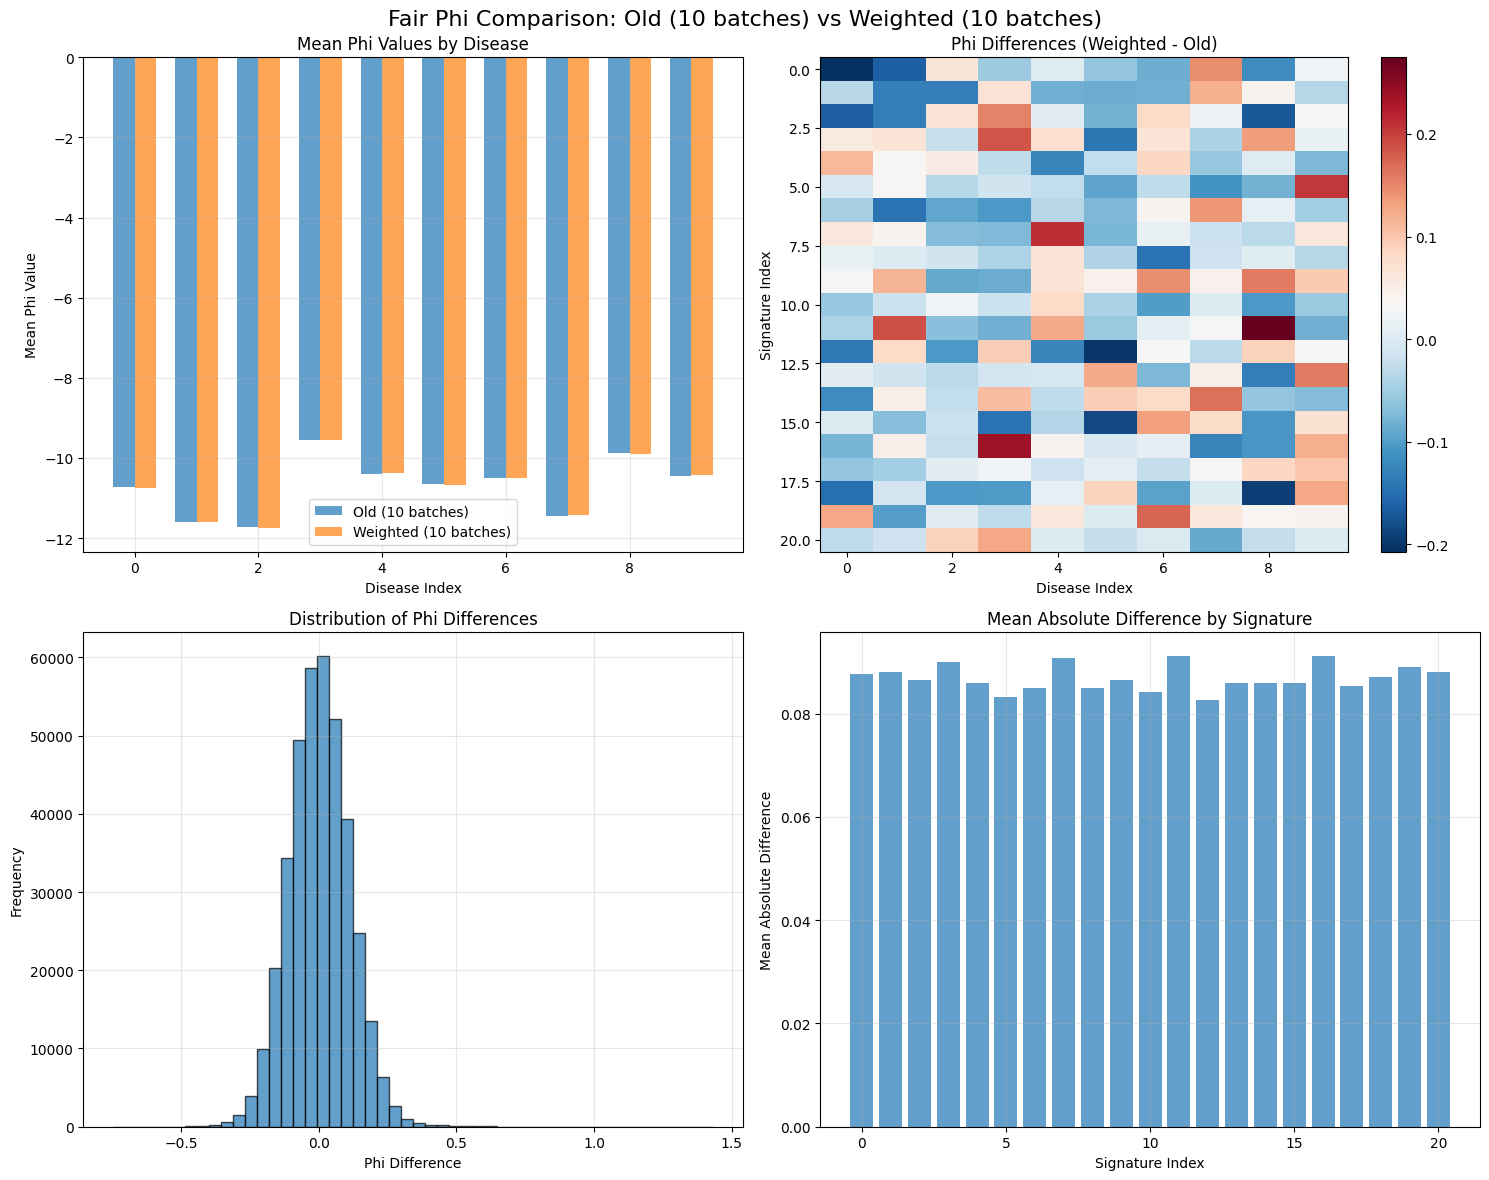

Fair phi comparison plot saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison.png

=== FAIR COMPARISON COMPLETE ===
Fair comparison results saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison_results.pt
Key findings:
  - Old model: 10 batches combined
  - Weighted model: 10 batches combined
  - Phi shapes match: True
  - Mean difference: 0.003521
  - Max absolute difference: 1.431260


In [ ]:
# FIXED PHI COMPARISON: Detach tensors before plotting

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the first 10 batches from the old model
old_model_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/'
print("=== LOADING OLD MODEL BATCHES ===")

old_phis = []
old_models = []

for batch_idx in range(10):
    model_path = os.path.join(old_model_dir, f'enrollment_model_W0.0001_batch_{batch_idx*10000}_{(batch_idx+1)*10000}.pt')
    
    if os.path.exists(model_path):
        print(f"Loading batch {batch_idx}: {model_path}")
        model = torch.load(model_path, map_location=torch.device('cpu'))
        old_phis.append(model['phi'].detach())  # Detach here
        old_models.append(model)
        print(f"  Phi shape: {model['phi'].shape}")
    else:
        print(f"⚠️  Batch {batch_idx} not found: {model_path}")

if len(old_phis) == 0:
    print("❌ No old model batches found!")
else:
    print(f"✅ Loaded {len(old_phis)} old model batches")
    
    # Combine phis from old models
    print("\n=== COMBINING OLD MODEL PHIS ===")
    phi_shape = old_phis[0].shape
    print(f"Phi shape: {phi_shape}")
    
    # Initialize combined old phi
    combined_old_phi = torch.zeros(phi_shape)
    
    # Sum phis from all old batches
    for i, phi in enumerate(old_phis):
        combined_old_phi += phi
        print(f"  Batch {i}: phi shape {phi.shape}")
    
    # Average the phis
    combined_old_phi /= len(old_phis)
    
    print(f"Combined old phi shape: {combined_old_phi.shape}")
    print(f"Combined old phi stats: mean={combined_old_phi.mean():.4f}, std={combined_old_phi.std():.4f}")

# Load combined phi from weighted training
print("\n=== LOADING WEIGHTED MODEL PHI ===")
combined_phi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted_vec_censoredE/combined_phi.pt'
combined_phi_data = torch.load(combined_phi_path, map_location=torch.device('cpu'))
combined_weighted_phi = combined_phi_data['phi'].detach()  # Detach here

print(f"Combined weighted phi shape: {combined_weighted_phi.shape}")
print(f"Combined weighted phi stats: mean={combined_weighted_phi.mean():.4f}, std={combined_weighted_phi.std():.4f}")
print(f"Combined from {combined_phi_data['num_batches']} batches")

# Compare the two combined phis
print(f"\n=== FAIR PHI COMPARISON ===")
print(f"Old model: {len(old_phis)} batches combined")
print(f"Weighted model: {combined_phi_data['num_batches']} batches combined")

# Check if shapes match
if combined_old_phi.shape != combined_weighted_phi.shape:
    print(f"⚠️  WARNING: Phi shapes don't match!")
    print(f"  Old combined: {combined_old_phi.shape}")
    print(f"  Weighted combined: {combined_weighted_phi.shape}")
else:
    print("✅ Phi shapes match!")

# Calculate differences
phi_diff = combined_weighted_phi - combined_old_phi
phi_abs_diff = torch.abs(phi_diff)

print(f"\n=== PHI DIFFERENCE STATISTICS ===")
print(f"Mean difference: {phi_diff.mean():.6f}")
print(f"Std difference: {phi_diff.std():.6f}")
print(f"Max absolute difference: {phi_abs_diff.max():.6f}")
print(f"Mean absolute difference: {phi_abs_diff.mean():.6f}")

# Create visualization comparing the two combined phis
def plot_fair_phi_comparison(old_phi, weighted_phi, max_diseases=10):
    """
    Plot comparison of combined phi values
    """
    K, D, T = old_phi.shape
    
    # Take first few diseases for visualization
    n_diseases = min(max_diseases, D)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fair Phi Comparison: Old (10 batches) vs Weighted (10 batches)', fontsize=16)
    
    # 1. Mean phi values across time for each disease
    ax1 = axes[0, 0]
    old_mean = old_phi[:, :n_diseases, :].mean(dim=2).detach().numpy()  # Detach and convert to numpy
    weighted_mean = weighted_phi[:, :n_diseases, :].mean(dim=2).detach().numpy()
    
    x_pos = np.arange(n_diseases)
    width = 0.35
    
    ax1.bar(x_pos - width/2, old_mean.mean(axis=0), width, label='Old (10 batches)', alpha=0.7)
    ax1.bar(x_pos + width/2, weighted_mean.mean(axis=0), width, label='Weighted (10 batches)', alpha=0.7)
    ax1.set_xlabel('Disease Index')
    ax1.set_ylabel('Mean Phi Value')
    ax1.set_title('Mean Phi Values by Disease')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Difference heatmap
    ax2 = axes[0, 1]
    phi_diff_subset = phi_diff[:, :n_diseases, :].mean(dim=2).detach().numpy()  # Detach and convert
    im = ax2.imshow(phi_diff_subset, aspect='auto', cmap='RdBu_r')
    ax2.set_xlabel('Disease Index')
    ax2.set_ylabel('Signature Index')
    ax2.set_title('Phi Differences (Weighted - Old)')
    plt.colorbar(im, ax=ax2)
    
    # 3. Distribution of differences
    ax3 = axes[1, 0]
    phi_diff_flat = phi_diff.flatten().detach().numpy()  # Detach and convert
    ax3.hist(phi_diff_flat, bins=50, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Phi Difference')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Phi Differences')
    ax3.grid(True, alpha=0.3)
    
    # 4. Absolute differences by signature
    ax4 = axes[1, 1]
    phi_abs_diff_mean = phi_abs_diff.mean(dim=(1, 2)).detach().numpy()  # Detach and convert
    ax4.bar(range(K), phi_abs_diff_mean, alpha=0.7)
    ax4.set_xlabel('Signature Index')
    ax4.set_ylabel('Mean Absolute Difference')
    ax4.set_title('Mean Absolute Difference by Signature')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Fair phi comparison plot saved to: {plot_path}")

# Create the fair comparison plot
if len(old_phis) > 0:
    plot_fair_phi_comparison(combined_old_phi, combined_weighted_phi)
    
    # Save fair comparison results
    fair_comparison_results = {
        'old_model_dir': old_model_dir,
        'weighted_model_path': combined_phi_path,
        'old_batches_combined': len(old_phis),
        'weighted_batches_combined': combined_phi_data['num_batches'],
        'phi_shapes_match': combined_old_phi.shape == combined_weighted_phi.shape,
        'mean_difference': phi_diff.mean().item(),
        'std_difference': phi_diff.std().item(),
        'max_absolute_difference': phi_abs_diff.max().item(),
        'mean_absolute_difference': phi_abs_diff.mean().item()
    }
    
    fair_comparison_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/batch_models_weighted/fair_phi_comparison_results.pt'
    torch.save(fair_comparison_results, fair_comparison_path)
    
    print(f"\n=== FAIR COMPARISON COMPLETE ===")
    print(f"Fair comparison results saved to: {fair_comparison_path}")
    print(f"Key findings:")
    print(f"  - Old model: {fair_comparison_results['old_batches_combined']} batches combined")
    print(f"  - Weighted model: {fair_comparison_results['weighted_batches_combined']} batches combined")
    print(f"  - Phi shapes match: {fair_comparison_results['phi_shapes_match']}")
    print(f"  - Mean difference: {fair_comparison_results['mean_difference']:.6f}")
    print(f"  - Max absolute difference: {fair_comparison_results['max_absolute_difference']:.6f}")
else:
    print("❌ Cannot perform fair comparison - no old model batches found!")

=== SAMPLE DISEASE PHI COMPARISON ===
Analyzing diseases: [112, 57, 19]


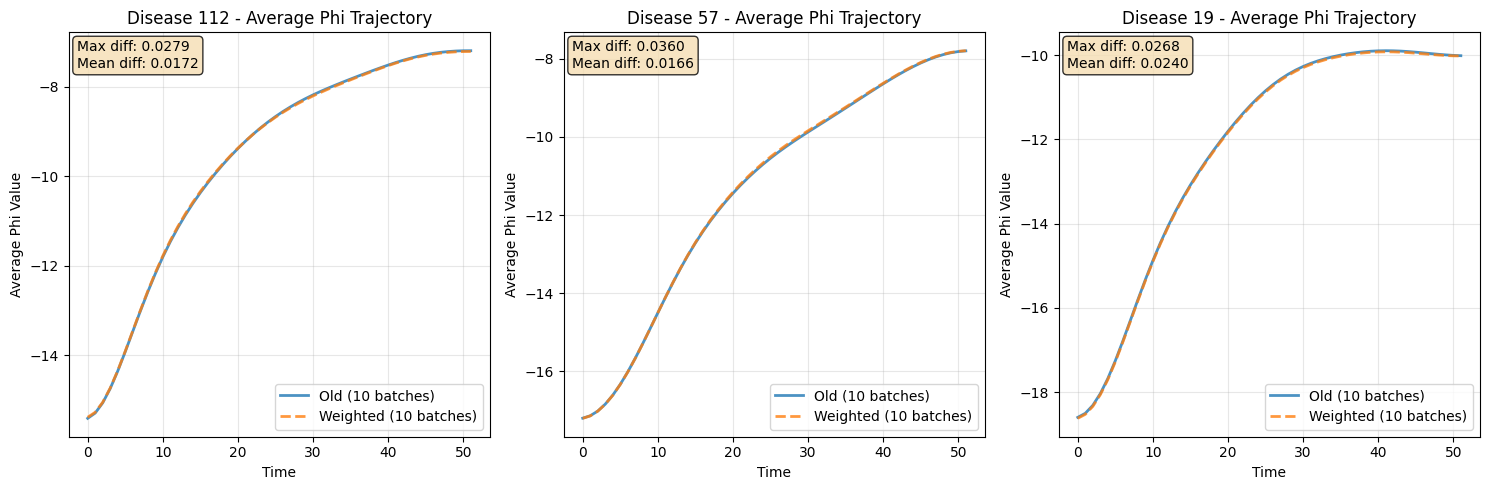

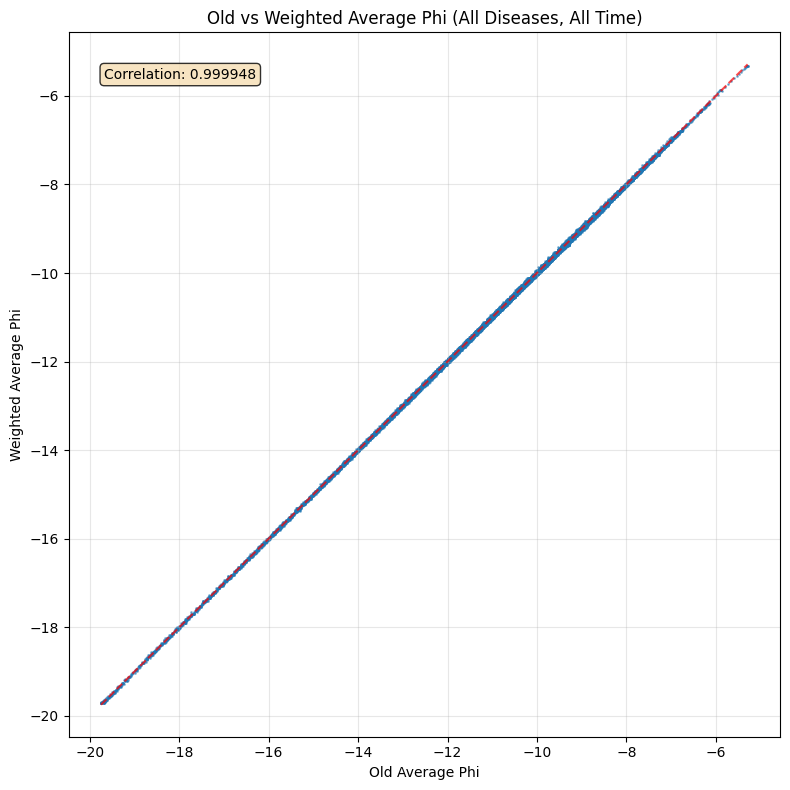

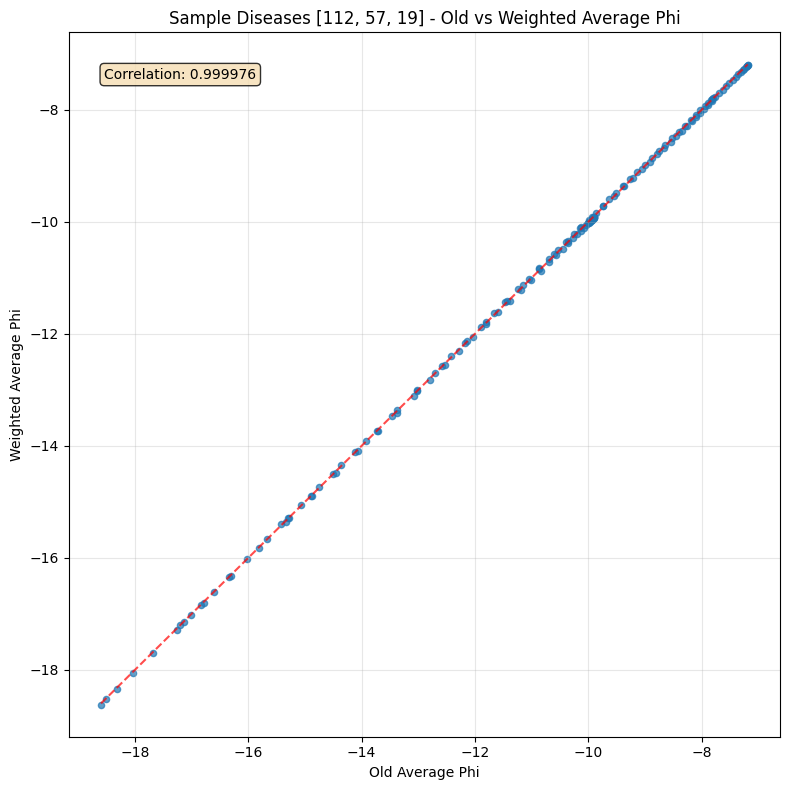


=== DETAILED STATISTICS FOR SAMPLE DISEASES ===

Disease 112:
  Mean old phi: -9.6073
  Mean weighted phi: -9.6093
  Mean difference: -0.002043
  Max absolute difference: 0.027896
  Mean absolute difference: 0.017245
  Correlation: 0.999989

Disease 57:
  Mean old phi: -11.3433
  Mean weighted phi: -11.3277
  Mean difference: 0.015636
  Max absolute difference: 0.036029
  Mean absolute difference: 0.016572
  Correlation: 0.999994

Disease 19:
  Mean old phi: -12.2199
  Mean weighted phi: -12.2440
  Mean difference: -0.024045
  Max absolute difference: 0.026751
  Mean absolute difference: 0.024045
  Correlation: 0.999999

=== OVERALL STATISTICS ===
Overall correlation: 0.999948
Overall mean difference: 0.003521
Overall max absolute difference: 0.117649
Overall mean absolute difference: 0.019345

✅ Sample disease analysis complete!


: 

In [ ]:
# SAMPLE DISEASE ANALYSIS: Compare old vs weighted phi for specific diseases

import matplotlib.pyplot as plt
import numpy as np

# Define sample diseases to analyze
sample_diseases = [112, 57, 19]  # You can change these to any disease indices you want
disease_names = ['Myocardial Infarction', 'Type 2 Diabetes', 'Essential Hypertension']  # Optional names

print("=== SAMPLE DISEASE PHI COMPARISON ===")
print(f"Analyzing diseases: {sample_diseases}")

# Calculate average phi across signatures for each disease
old_avg_phi = combined_old_phi.mean(dim=0)  # Average across signatures: shape (348, 52)
weighted_avg_phi = combined_weighted_phi.mean(dim=0)  # Average across signatures: shape (348, 52)

# 1. Plot averaged phi trajectories for sample diseases
fig, axes = plt.subplots(1, len(sample_diseases), figsize=(15, 5))
if len(sample_diseases) == 1:
    axes = [axes]

for i, disease_idx in enumerate(sample_diseases):
    ax = axes[i]
    
    # Get trajectories for this disease
    old_traj = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_traj = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    # Plot trajectories
    ax.plot(old_traj, label='Old (10 batches)', linewidth=2, alpha=0.8)
    ax.plot(weighted_traj, label='Weighted (10 batches)', linewidth=2, alpha=0.8, linestyle='--')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Phi Value')
    ax.set_title(f'Disease {disease_idx} - Average Phi Trajectory')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add some statistics
    diff = np.abs(weighted_traj - old_traj)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    ax.text(0.02, 0.98, f'Max diff: {max_diff:.4f}\nMean diff: {mean_diff:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 2. Scatter plot of all old vs weighted average phi values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Flatten all values for scatter plot
old_flat = old_avg_phi.detach().numpy().flatten()
weighted_flat = weighted_avg_phi.detach().numpy().flatten()

# Create scatter plot
ax.scatter(old_flat, weighted_flat, alpha=0.5, s=1)
ax.plot([old_flat.min(), old_flat.max()], [old_flat.min(), old_flat.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Average Phi')
ax.set_ylabel('Weighted Average Phi')
ax.set_title('Old vs Weighted Average Phi (All Diseases, All Time)')
ax.grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Focus on sample diseases scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Get values for sample diseases only
sample_old_values = []
sample_weighted_values = []

for disease_idx in sample_diseases:
    old_vals = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_vals = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    sample_old_values.extend(old_vals)
    sample_weighted_values.extend(weighted_vals)

sample_old_values = np.array(sample_old_values)
sample_weighted_values = np.array(sample_weighted_values)

# Create scatter plot for sample diseases
ax.scatter(sample_old_values, sample_weighted_values, alpha=0.7, s=20)
ax.plot([sample_old_values.min(), sample_old_values.max()], 
        [sample_old_values.min(), sample_old_values.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Average Phi')
ax.set_ylabel('Weighted Average Phi')
ax.set_title(f'Sample Diseases {sample_diseases} - Old vs Weighted Average Phi')
ax.grid(True, alpha=0.3)

# Calculate correlation for sample diseases
sample_correlation = np.corrcoef(sample_old_values, sample_weighted_values)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {sample_correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Print detailed statistics for sample diseases
print(f"\n=== DETAILED STATISTICS FOR SAMPLE DISEASES ===")
for i, disease_idx in enumerate(sample_diseases):
    old_traj = old_avg_phi[disease_idx, :].detach().numpy()
    weighted_traj = weighted_avg_phi[disease_idx, :].detach().numpy()
    
    diff = weighted_traj - old_traj
    abs_diff = np.abs(diff)
    
    print(f"\nDisease {disease_idx}:")
    print(f"  Mean old phi: {old_traj.mean():.4f}")
    print(f"  Mean weighted phi: {weighted_traj.mean():.4f}")
    print(f"  Mean difference: {diff.mean():.6f}")
    print(f"  Max absolute difference: {abs_diff.max():.6f}")
    print(f"  Mean absolute difference: {abs_diff.mean():.6f}")
    print(f"  Correlation: {np.corrcoef(old_traj, weighted_traj)[0, 1]:.6f}")

# 5. Overall statistics
print(f"\n=== OVERALL STATISTICS ===")
overall_correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
overall_diff = weighted_flat - old_flat
overall_abs_diff = np.abs(overall_diff)

print(f"Overall correlation: {overall_correlation:.6f}")
print(f"Overall mean difference: {overall_diff.mean():.6f}")
print(f"Overall max absolute difference: {overall_abs_diff.max():.6f}")
print(f"Overall mean absolute difference: {overall_abs_diff.mean():.6f}")

print(f"\n✅ Sample disease analysis complete!")

In [ ]:
# CORRECTED SAMPLE DISEASE ANALYSIS: Compare old vs weighted phi for each signature

import matplotlib.pyplot as plt
import numpy as np

# Define sample diseases to analyze
sample_diseases = [112,57,47,19]  # You can change these to any disease indices you want

print("=== SAMPLE DISEASE PHI COMPARISON (PER SIGNATURE) ===")
print(f"Analyzing diseases: {sample_diseases}")

# 1. Plot phi trajectories for each signature for sample diseases
fig, axes = plt.subplots(1, len(sample_diseases), figsize=(15, 5))
if len(sample_diseases) == 1:
    axes = [axes]

for i, disease_idx in enumerate(sample_diseases):
    ax = axes[i]
    
    # Plot phi trajectories for each signature (K) for this disease
    for k in range(combined_old_phi.shape[0]):  # All signatures (K=21)
        old_traj = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_traj = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        ax.plot(old_traj, alpha=0.7, linestyle='-', label=f'Sig {k} (old)' if i == 0 else "")
        ax.plot(weighted_traj, alpha=0.7, linestyle='--', label=f'Sig {k} (new)' if i == 0 else "")
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Phi Value')
    ax.set_title(f'Disease {disease_idx} - Phi Trajectories (All Signatures)')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 2. Scatter plot of all old vs weighted phi values (each K, each D, each T)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Flatten all values for scatter plot (K, D, T)
old_flat = combined_old_phi.detach().numpy().flatten()
weighted_flat = combined_weighted_phi.detach().numpy().flatten()

# Create scatter plot
ax.scatter(old_flat, weighted_flat, alpha=0.5, s=1)
ax.plot([old_flat.min(), old_flat.max()], [old_flat.min(), old_flat.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Phi')
ax.set_ylabel('Weighted Phi')
ax.set_title('Old vs Weighted Phi (All K, All D, All T)')
ax.grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Focus on sample diseases scatter plot (each K, each T for sample diseases)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Get values for sample diseases only (each K, each T)
sample_old_values = []
sample_weighted_values = []

for disease_idx in sample_diseases:
    for k in range(combined_old_phi.shape[0]):  # All signatures
        old_vals = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_vals = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        sample_old_values.extend(old_vals)
        sample_weighted_values.extend(weighted_vals)

sample_old_values = np.array(sample_old_values)
sample_weighted_values = np.array(sample_weighted_values)

# Create scatter plot for sample diseases
ax.scatter(sample_old_values, sample_weighted_values, alpha=0.7, s=20)
ax.plot([sample_old_values.min(), sample_old_values.max()], 
        [sample_old_values.min(), sample_old_values.max()], 'r--', alpha=0.7)

ax.set_xlabel('Old Phi')
ax.set_ylabel('Weighted Phi')
ax.set_title(f'Sample Diseases {sample_diseases} - Old vs Weighted Phi (All K, All T)')
ax.grid(True, alpha=0.3)

# Calculate correlation for sample diseases
sample_correlation = np.corrcoef(sample_old_values, sample_weighted_values)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {sample_correlation:.6f}', transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Print detailed statistics for sample diseases (per signature)
print(f"\n=== DETAILED STATISTICS FOR SAMPLE DISEASES (PER SIGNATURE) ===")
for i, disease_idx in enumerate(sample_diseases):
    print(f"\nDisease {disease_idx}:")
    
    for k in range(combined_old_phi.shape[0]):  # All signatures
        old_traj = combined_old_phi[k, disease_idx, :].detach().numpy()
        weighted_traj = combined_weighted_phi[k, disease_idx, :].detach().numpy()
        
        diff = weighted_traj - old_traj
        abs_diff = np.abs(diff)
        
        print(f"  Signature {k}:")
        print(f"    Mean old phi: {old_traj.mean():.4f}")
        print(f"    Mean weighted phi: {weighted_traj.mean():.4f}")
        print(f"    Mean difference: {diff.mean():.6f}")
        print(f"    Max absolute difference: {abs_diff.max():.6f}")
        print(f"    Mean absolute difference: {abs_diff.mean():.6f}")
        print(f"    Correlation: {np.corrcoef(old_traj, weighted_traj)[0, 1]:.6f}")

# 5. Overall statistics
print(f"\n=== OVERALL STATISTICS ===")
overall_correlation = np.corrcoef(old_flat, weighted_flat)[0, 1]
overall_diff = weighted_flat - old_flat
overall_abs_diff = np.abs(overall_diff)

print(f"Overall correlation: {overall_correlation:.6f}")
print(f"Overall mean difference: {overall_diff.mean():.6f}")
print(f"Overall max absolute difference: {overall_abs_diff.max():.6f}")
print(f"Overall mean absolute difference: {overall_abs_diff.mean():.6f}")

print(f"\n✅ Sample disease analysis complete!")